       A   B          v(A)          v(B)  r(AXII)(Å)  r(AVI)(Å)  r(BVI)(Å)  \
2799  38  56  3.570731e-01  1.194823e+00   -0.845750  -0.963509  -0.514553   
1796  24  59 -4.807868e-14  3.397588e-14    0.489467   1.162370   0.101346   
1081  14  67 -4.807868e-14  3.397588e-14    2.685159   3.451778  -0.719853   
473    6  35 -4.807868e-14  3.397588e-14    1.884028   2.143545   0.840425   
5075  70  18  1.270690e+00  5.055716e-01    0.192752   0.508253   0.553006   
...   ..  ..           ...           ...         ...        ...        ...   
2383  32  64 -4.807868e-14  3.397588e-14   -0.252320  -0.432040   1.579504   
119    1  46 -1.470160e+00 -1.562182e+00    0.904868   0.508253  -0.596673   
2826  39  13 -1.470160e+00 -1.562182e+00    0.014723   0.140312  -0.966212   
738   10   9 -4.807868e-14  3.397588e-14    0.993883   0.508253   0.758305   
5142  71  12  3.570731e-01  1.194823e+00   -0.222649  -0.350275  -1.171512   

         EN(A)     EN(B)  l(A-O)(Å)  l(B-O)(Å)      ΔENR       

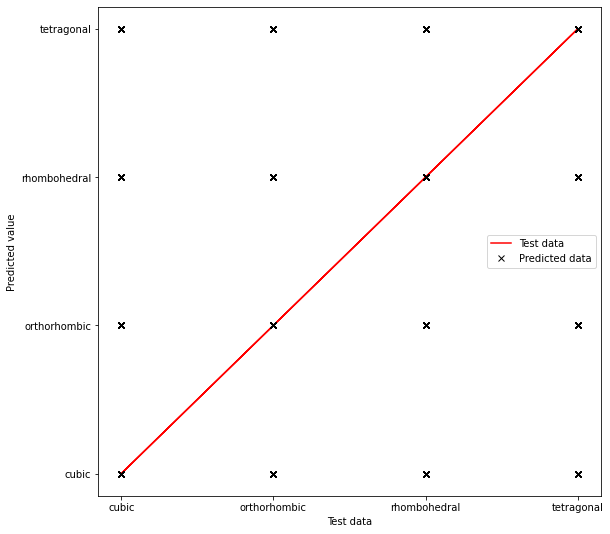

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
import math
import sklearn.metrics as metrics

class Preprocessor():
    def __init__(self, file_directory: str, not_number: list, filetype: str = "csv", 
                 encodetype: str = "label", useScaler: bool = False, scaletype: str = "minmax", 
                 replaceNAN: bool = True):
        """Init function
            Inputs: 
            file_directory: directory of the file relative to script.
            filetype: type of file to be imported (defaulted as csv).
            not_number: map of columns -> bool based on if the values of the column are not numbers.
            encodetype: type of encoder to be used (ONLY onehot or label). Defaulted to label
            replace: true if all N/A values should be replaced by the mean of the column, false if row
            containing N/A should be ommitted (defaulted to true).
            
            Returns: None"""
        
        # add attributes
        self.dir = file_directory
        self.boolmap = not_number
        self.filetype = filetype
        self.scale = useScaler
        self.replaceNAN = replaceNAN
        
        # make sure encodetype is either onehot or label
        encode_check = encodetype in ("onehot", "label")
        assert encode_check, f"Unexpected encode type '{encodetype}'. Preprocessor only takes onehot or label encoding"
        # add encoder attribute
        self.encodetype = encodetype
        
        # only run if useScaler is true, else scaletype won't be defined.
        if(useScaler == True):
            # make sure scaletype is either minmax or standard
            scale_check = scaletype in ("minmax", "standard")
            assert scale_check, f"Unexpected scaling type '{scaletype}'. Preprocessor only takes minmax or standard scaling"
            # add scaler attribute
            self.scaletype = scaletype
        
    

    def Process(self) -> pd.DataFrame:
        """Calls all other functions within class and runs until a 
            clean, encoded Dataframe is returned to the user
            Inputs: 
            self: contains attributes (refer to notes at __init__)
            
            Returns: pandas dataframe of fully preprocessed data"""
        
        # first we import the file:
        raw_data = self.ImportAsDf()
        # we then clean the data:
        clean_data, worded_columns = self.CleanData(raw_data)
        # next we encode the necessary worded data:
        encoded_data = self.Encode(clean_data, worded_columns)
        
        # if useScaler is true, scale the non-encoded numerated data:
        if(self.scale == True):
            # get list of non-encoded numerated columns
            numbered_columns = [i for i in encoded_data.columns if i not in worded_columns]
            
            # scale data
            scaled = self.Scale(encoded_data, numbered_columns)
            return scaled
        
        else: return encoded_data
    
    
    def ImportAsDf(self) -> pd.DataFrame:
        """Grabs file and imports it as a pandas Dataframe.
            Inputs: 
            self: contains attributes (refer to notes at __init__).

            Returns: pandas dataframe of the raw data"""

        if(self.filetype == "csv"):
            return pd.read_csv(self.dir)
        return None

    
    def CleanData(self, data: pd.DataFrame) -> tuple:
        """Goes through the data and removes/replaces any N/A values, as well
           returning any worded columns to to be encoded.
            Inputs: 
            self: contains attributes (refer to notes at __init__).
            data: data to be cleaned. 

            Returns: tuple: 
                   0: pandas dataframe of the cleaned data
                   1: list of all worded columns to be encoded"""

        #reset index of data 
        data = data.reset_index(drop=True)
        #remove unnecessary columns
        data = data.drop(["Compound", "In literature"], axis=1)
        #replace all "-" with NAN
        data = data.replace("-", np.nan)

        #get two lists of columns split on whether their values are numbers or not:
        numerated_columns = [data.columns[i] for i in range(len(data.columns)) if self.boolmap[i] == False]
        worded_columns = [data.columns[i] for i in range(len(data.columns)) if self.boolmap[i] == True]

        # we first search through worded columns and remove row where NA is present, since mean method will not work:
        for column in worded_columns:
            removal_list=[]
            
            # go through every value in worded column
            for i, value in enumerate(data[column]):
                
                # add row index of each occurance of NAN
                if(pd.isna(value)): removal_list.append(i)
            
            # remove once iteration is complete to avoid issues with index i:
            data.drop(removal_list, inplace=True)

        
        # we then search through numbered columns, and either replace NA with a mean or remove column    
        if(self.replaceNAN== True):
            for column in numerated_columns:
                #find mean of column (convert all values in columns to floats before averaging)
                column_mean = data[column].astype(float).mean(skipna= True)
                
                #replace na values on column with mean
                data[column] = data[column].apply(lambda x: column_mean if pd.isna(x) == True else x)
            
            return (data.reset_index(drop=True), worded_columns)
        
        
        else: # remove NA values if repalce is set to false:
            return (data.dropna().reset_index(drop=True), worded_columns)

    
    def Encode(self, data: pd.DataFrame, encode_columns: list) -> pd.DataFrame:
        """Encodes columns either using a label encoder or a onehot encoder.
            Inputs:
            self: contains attributes (refer to notes at __init__)
            data: data to be encoded.
            encode_columns: list of columns by label to be encoded
            
            Returns:
            Pandas dataframe of the encoded data"""
        
        # exclude final column from being encoded since it is the dependant variable
        encode_columns = encode_columns[:-1]
        
        #check if onehot or label encoder is being used
        if(self.encodetype == "onehot"):
            for column in encode_columns:
                # grab a list of distinct categories
                categories = sorted(set(data[column]))
                
                # go through each category and make a new column with binary values 0 or 1
                for category in categories:
                    data[f"{column}_{category}"] = data[column].apply(lambda x: 1 if x == category else 0)
                
                #drop column
                data.drop(column, axis=1, inplace = True)
                
            return data
        
        else: # must be label due to previous assertion
            for column in encode_columns:
                # grab a list of distinct categories
                categories = sorted(set(data[column]))
                
                # map these categories to integers:
                category_map = {categories[i] : i for i in range(len(categories))}
                
                # apply value using the map
                data[column] = data[column].apply(lambda x: category_map[x])
            
            return data
    
    
    def Scale(self, data: pd.DataFrame, scale_columns: list) -> pd.DataFrame:
        """Scales the data based on the minmax or standard approach
            Inputs:
            self: contains attributes (refer to notes at __init__)
            data: data to be scaled.
            scale_columns: list of columns by label to be scaled
            
            Returns:
            Pandas dataframe of the scaled data"""
        
        # check if minmax or standard scaler is being used
        if (self.scaletype == "minmax"):
            # for each column of the data find the minimum and maximum values:
            for column in scale_columns:
                # make all values in column a float
                data[column] = data[column].astype(float)
                
                min_value, max_value = (data[column].min(), data[column].max())
                column_range = max_value - min_value
                
                # change data using minmax equation:
                data[column] = data[column].apply(lambda x: (x - min_value)/column_range)
            
            return data
        
        else: # must be standard due to previous assertion
            # for each column of the data, find the mean and standard deviation
            for column in scale_columns:
                # make all values in column a float
                data[column] = data[column].astype(float)
                
                mean, std = (data[column].mean(), data[column].std())
                
                # change data using standard equation:
                data[column] = data[column].apply(lambda x: (x - mean)/std)
            
            return data




# create boolean map of columns where non-numeric columns are True, excluding items that want to be ignored
classmap = [True, True, False, False, False, False, False, False, False,
           False, False, False, False, False, False, True]

file_directory = "Crystal_structure.csv"

# get preprocessed data
clean = Preprocessor(file_directory, classmap, replaceNAN = True, useScaler = True, scaletype = "standard").Process()



def SplitData(data: pd.DataFrame, train_ratio: float = 0.1) -> tuple:
    """Splits data into train and test samples
        Inputs:
        data: data to be split
        train_ratio: the ratio of train to test array size for the data.
        (defaulted to 10% train with 90% test data)
        
        Returns: tuple:
                 0: pandas DataFrame of train data for independent variables.
                 1: pandas DataFrame of test data for independent variables.
                 2: pandas Series of train data for dependent variable.
                 3: pandas Series of test data for dependent variable."""
    
    # find index where data should be split
    index = int(train_ratio * len(data.index))
    
    # Make a list of dependent and independant variables:
    X_columns = list(data.columns)
    y_columns = X_columns.pop(-1)
    
    # split X and y data into test and training data for each
    train = data.sample(frac=train_ratio, random_state = 200)
    test = data.drop(train.index)
    
    return train[X_columns], test[X_columns], train[y_columns], test[y_columns]
    


def KNN(data): 
    X_train, X_test, y_train, y_test = data
    
    #print(y_train.head(50))

    #print(math.sqrt(len(y_test)))
    classifier = knn(n_neighbors = 1, p=2, metric = "euclidean")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    print(set(y_pred))

    score = metrics.f1_score(y_test, y_pred, average = "micro")
    #print(score)

    false_score = metrics.accuracy_score(y_test, y_pred)
    #print(score)
    
    print(metrics.classification_report( y_test, y_pred ))

    fig, ax = plt.subplots(figsize = (9,9))
    ax.plot(y_test, y_test, "r-", label = "Test data")
    ax.plot(y_test, y_pred, "kx", label = "Predicted data")
    ax.set_ylabel("Predicted value")
    ax.set_xlabel("Test data")
    ax.legend()
    


def Logistic(data):
    X_train, X_test, y_train, y_test = data

    #print(list(y_test)[:200])
    regression = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000) 
    regression.fit(X_train, y_train)

    y_prediction = regression.predict(X_test)
    #print(y_prediction[:200])
    #print(regression.score(X_test, y_test))

    #print(metrics.f1_score(y_test, y_pred, average="weighted"), metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report( y_test, y_prediction ))
    fig, ax = plt.subplots(figsize = (9,9))
    ax.plot(y_test, y_test, "r-", label = "Test data")
    ax.plot(y_test, y_prediction, "kx", label = "Predicted data")
    ax.set_ylabel("Predicted value")
    ax.set_xlabel("Test data")
    ax.legend()
    
# split data
X_train, X_test, y_train, y_test = SplitData(clean)
print(X_train)
#print(X_test)

Logistic(SplitData(clean))